# Investigate the Data

Welcome to the cumulative project on clustering algorithms! In this project, we will be investigating the way people think about masculinity by applying the KMeans algorithm to data from  <a href="https://fivethirtyeight.com/" target = "_blank">FiveThirtyEight</a>. FiveThirtyEight is a popular website known for their use of statistical analysis in many of their stories.

To begin, take a look at `masculinity-survey.pdf`. FiveThirtyEight and WNYC studios used this survey to get their male readers' thoughts on masculinity. After looking through some of the questions asked, take a look at FiveThirtyEight's article <a href="https://fivethirtyeight.com/features/what-do-men-think-it-means-to-be-a-man/" target = "_blank">What Do Men Think It Means To Be A Man?</a> to see their major takeaways. We're going to try to find more insights using machine learning.

In the code block below, we've loaded `masculinity.csv` into a DataFrame named `survey`. This file contains the raw responses to the masculinity survey. Let's start getting a sense of how this data is structured. Try to answer these questions using your Pandas knowledge:
* What are the names of the columns? How do those columns relate to the questions in the PDF?
* How many rows are there?
* How is a question with multiple parts, like question 7, represented in the DataFrame?
* How many people said they often ask a friend for professional advice? This is the first sub-question in question 7.

To answer that last question, use the `value_counts()` function. For example, `df["col_a"].value_counts()` gives you a nice summary of the values found in `"col_a"` of the DataFrame `df`.

You may also want to print `survey.head()` to get a sense of all of the columns.


In [24]:
import pandas as pd

survey = pd.read_csv("masculinity.csv")
print(survey["q0007_0011"])


0                           Often
1                       No answer
2       Never, and not open to it
3       Never, and not open to it
4                       Sometimes
                  ...            
1184                    No answer
1185                       Rarely
1186                    Sometimes
1187                       Rarely
1188                       Rarely
Name: q0007_0011, Length: 1189, dtype: object


# Mapping the Data

In order for us to start thinking about using the KMeans algorithm with this data, we need to first figure out how to turn these responses into numerical data. Let's once again consider question 7. We can't cluster the data using the phrases `"Often"` or `"Rarely"`, but we can turn those phrases into numbers. For example, we could map the data in the following way: 
* `"Often"` -> `4`
* `"Sometimes"` ->  `3`
* `"Rarely"` -> `2` 
* `"Never, but open to it"` -> `1`
* `"Never, and not open to it"` -> `0`.

Note that it's important that these responses are somewhat linear. `"Often"` is at one end of the spectrum with `"Never, and not open to it"` at the other. The other values fall in sequence between the two. You could perform a similar mapping for the `"educ4"` responses (question 29), but there isn't an obvious linear progression in the `"racethn4"` responses (question 28).

In order to do this transformation, use the `map()` function. `map()` takes a dictionary as a parameter. For example, the following line of code would turn all the `"A"`s into `1`s and all the `"B"`s into `2`s in the column `"col_one"`.

```py
df["col_one"] = df["col_one"].map({"A": 1, "B": 2})
```

We've given you a list of the columns that should be mapped. Loop through the values of the list and map each column using the mapping described above.

Be careful of your spelling! Punctuation and whitespace is important. Take a look at the `value_counts()` of one of these columns to see if the mapping worked.


In [25]:
cols_to_map = ["q0007_0001", "q0007_0002", "q0007_0003", "q0007_0004",
       "q0007_0005", "q0007_0006", "q0007_0007", "q0007_0008", "q0007_0009",
       "q0007_0010", "q0007_0011"]
for i in range (11):
    survey[(cols_to_map[i])] = survey[(cols_to_map[i])].map({"Often": 4, "Sometimes": 3,"Rarely":2, "Never, but open to it":1,"Never, and not open to it":0})
print(survey[(cols_to_map)])

      q0007_0001  q0007_0002  q0007_0003  q0007_0004  q0007_0005  q0007_0006  \
0            4.0         4.0         4.0         4.0         0.0         0.0   
1            2.0         3.0         1.0         2.0         0.0         2.0   
2            3.0         3.0         3.0         2.0         1.0         4.0   
3            2.0         2.0         3.0         2.0         2.0         4.0   
4            3.0         2.0         0.0         1.0         1.0         3.0   
...          ...         ...         ...         ...         ...         ...   
1184         3.0         3.0         4.0         3.0         3.0         3.0   
1185         3.0         3.0         2.0         2.0         1.0         4.0   
1186         4.0         3.0         0.0         3.0         2.0         4.0   
1187         1.0         1.0         0.0         0.0         3.0         3.0   
1188         2.0         2.0         2.0         0.0         0.0         3.0   

      q0007_0007  q0007_0008  q0007_000

# Plotting the Data

We now have 11 different features that we could use in our KMeans algorithm. Before we jump into clustering, let's graph some of these features on a 2D graph. Call `plt.scatter` using `survey["q0007_0001"]` and `survey["q0007_0002"]` as parameters. Include `alpha = 0.1`. We want to include `alpha` because many of the data points will be on top of each other. Adding `alpha` will make the points appear more solid if there are many stacked on top of each other.

Include axis labels on your graph. The x-axis corresponds with the first column you gave the `scatter()` function. So in this case, it corresponds to the question about asking a friend for professional advice.

Does it make sense that there are few points in the top left and bottom right corners of the graph? Why? Try graphing other dimensions against each other. Are there any combinations that give you surprising results?


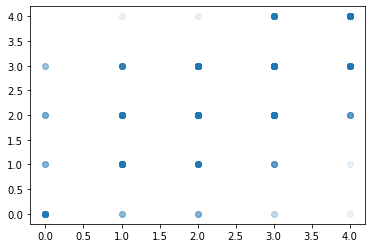

In [26]:
from matplotlib import pyplot as plt
plt.scatter((survey["q0007_0001"]),(survey["q0007_0002"]),alpha = 0.1)
plt.show()

# Build the KMeans Model

It's now time to start clustering! There are so many interesting questions we could ask about this data. Let's start by seeing if clusters form based on traditionally masculine concepts. 

Take a look at the first four sub-questions in question 7. Those four activities aren't necessarily seen as traditionally masculine. On the other hand, sub-questions 5, 8, and 9 are often seen as very masculine activities. What would happen if we found 2 clusters based on those 7 questions? Would we find clusters that represent traditionally feminine and traditionally masculine people? Let's find out.

We need to first drop all of the rows that contain a `NaN` value in any of the columns we're interested in. Create a new variable named `rows_to_cluster` and set it equal to the result of calling `dropna` on `survey`. `dropna` should have a parameter `subset` equal to a list of the 7 columns we want. If you don't include `subset`, the function will drop all rows that have an `NaN` in *any* column. This would drop almost all the rows in the dataframe!

Create a `KMeans` object named `classifier` where `n_clusters = 2`. Call `classifier`'s `.fit()` method. The parameter of `.fit()` should be the 7 columns we're interested in. For example, the following line of code will fit the model based on the columns `"col_one"` and `"col_two"` of the Dataframe `df`. 

```py
classifier.fit(df[["col_one", "col_two"]])
```

Make sure to only include the columns that you want to train off of. Make sure to use `rows_to_cluster` rather than `survey` to avoid including those `NaN`s!



After fitting your model, print out the model's `cluster_centers_`.


In [27]:
from sklearn.cluster import KMeans
rows_to_cluster = survey.dropna(subset= ["q0007_0001", "q0007_0002", "q0007_0003", "q0007_0004",
       "q0007_0005", "q0007_0008", "q0007_0009"])
classifier = KMeans(n_clusters = 2)
classifier.fit(rows_to_cluster[["q0007_0001", "q0007_0002", "q0007_0003", "q0007_0004",
       "q0007_0005", "q0007_0008", "q0007_0009"]])
print(classifier.cluster_centers_)


[[1.87830688 1.84391534 0.85185185 1.72486772 0.57142857 2.64021164
  1.97089947]
 [2.84548105 2.81632653 2.84110787 2.39941691 0.69387755 3.06997085
  2.90087464]]


# Separate the Cluster Members

When we look at the two clusters, the first four numbers represent the traditionally feminine activities and the last three represent the traditionally masculine activities. If the data points separated into a feminine cluser and a masculine cluseter, we would expect to see one cluster to have high values for the first four numbers and the other cluster to have high values for the last three numbers.

Instead, the first cluster has a higher value in every feature. Since a higher number means the person was more likely to "often" do something, the clusters seem to represent "people who do things" and "people who don't do things".

We might be able to find out more information about these clusters by looking at the specific members of each cluster. Print `classifier.labels_`. This list shows which cluster every row in the DataFrame corresponds to.

For example,  if `classifier.labels_` was `[1, 0 ,1]`, then the first row in the DataFrame would be in cluster one, the second row would be in cluster 0, and the third row would be in cluster one. A row represents one persons answers to every question in the survey.

Create two new empty lists named `cluster_zero_indices` and `cluster_one_indices`. Loop through `classifier.labels_` and whenever a label is `0` add that index to `cluster_zero_indices`. Do the same whenever a label is a `1`.

Print `cluster_zero_indices`

In [29]:
print(classifier.labels_)
cluster_zero_indices = []
cluster_one_indices=[]
labels = classifier.labels_
for i, label in enumerate(labels):
    if label == 0:
        cluster_zero_indices.append(i)
    elif label == 1:
        cluster_one_indices.append(i)
print(cluster_zero_indices)

[1 0 1 ... 0 0 0]
[1, 4, 6, 7, 9, 10, 12, 14, 17, 18, 19, 24, 29, 35, 39, 42, 49, 51, 52, 53, 54, 55, 57, 58, 62, 63, 65, 66, 75, 78, 79, 82, 84, 86, 87, 88, 89, 90, 92, 94, 95, 97, 98, 101, 106, 107, 109, 113, 116, 117, 118, 119, 123, 128, 129, 130, 131, 132, 134, 139, 142, 143, 154, 172, 175, 176, 178, 179, 180, 181, 184, 187, 189, 195, 196, 198, 199, 201, 209, 212, 222, 229, 230, 231, 233, 236, 237, 240, 241, 247, 248, 249, 250, 256, 260, 261, 263, 264, 272, 275, 281, 283, 284, 286, 288, 291, 296, 297, 299, 300, 301, 305, 310, 311, 325, 328, 331, 336, 337, 340, 341, 343, 347, 350, 351, 353, 361, 367, 369, 377, 378, 390, 391, 392, 393, 394, 396, 397, 398, 399, 409, 410, 411, 412, 415, 417, 418, 419, 425, 428, 429, 432, 449, 454, 455, 457, 459, 461, 463, 468, 470, 471, 476, 477, 478, 484, 489, 490, 493, 494, 496, 498, 499, 502, 508, 509, 510, 515, 516, 521, 523, 525, 526, 529, 531, 533, 542, 546, 549, 555, 556, 559, 560, 562, 563, 564, 566, 567, 570, 577, 579, 580, 585, 588, 589, 592,

# Investigate the Cluster Members

Now that we have the indices for each cluster, let's look at some stats about these two clusters. You can get the rows of the DataFrame that correspond to cluster zero by doing the following:

```py
cluster_zero_df = rows_to_cluster.iloc[cluster_zero_indices]
```

Do the same for `cluster_one_df`.

Finally, let's look at some information about these two clusters. Print the `value_counts()` of the `educ4` column of each cluster. What do you notice? Try looking at different columns. For example, are the people in cluster zero significantly older than those in cluster one? You can look at the `age3` column to see.

If you divide the result of `value_counts()` by the size of the cluster, you get the percentage of people in each category rather than the total number. This will make it easier to compare the two clusters.

In [31]:
cluster_zero_df = rows_to_cluster.iloc[cluster_zero_indices]
cluster_one_df = rows_to_cluster.iloc[cluster_one_indices]
print(cluster_zero_df['educ4'].value_counts())
print(cluster_one_df['educ4'].value_counts())

Some college            119
College or more         108
Post graduate degree     95
High school or less      55
Name: educ4, dtype: int64
Post graduate degree    251
College or more         227
Some college            158
High school or less      50
Name: educ4, dtype: int64


# Explore on Your Own

Great work! You've found out that by answering those 7 questions people don't fall into a "masculine" category or a "feminine" category. Instead, they seem to be divided by their level of education!

Now it's time for you to explore this data on your own. In this project, we've really focused on question 7 and its sub-questions. Take a look at some of the other questions in the survey and try to ask yourself some interesting questions. Here's a list of questions you could dive into:

* Which demographic features have stronger correlations with ideas of masculinity (sexual orientation, age, race, marital status, parenthood?)
* Are certain beliefs or actions linked to more self-described masculine or feminine individuals?
* How do insecurities change as people grow older?


Special thanks to the team at FiveThirtyEight and specifically Dhrumil Mehta for giving us access to the data!
